# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use a subset of the GitHub error dataset --> ename == valueerror

### Clustering value errors

load tokenized error dataset, evalue_tokenized

In [4]:
import pandas as pd 
import cluster_util

path = r"C:\Users\yirwa29\Downloads\Dataset-Nb\nbdata_g_error\analysis_gerr"

df2_err = pd.read_excel(path + '/nberror_g_all_p6_evaluetokenized.xlsx')
df2_err_ename = df2_err[df2_err['ename']=='valueerror']
err_descs = df2_err_ename['evalue_tokenized'].values.astype('U')

### 1 Vectorization
##### 1. tfidf
too high dimension - 7069

In [6]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

(15570, 7069)

In [7]:
import numpy as np

with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_tfidf.txt', 'wb') as f:
    np.save(f, X_tfidf)

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector, dimension -384

2 embeddings with different preprocessing

In [8]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

(15570, 384)

In [9]:
with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_transformers.txt', 'wb') as f:
    np.save(f, X_transformers)

In [10]:
df2_err_ename['evalue_tokenized_transformer'] = df2_err_ename['evalue'].apply(cluster_util.preprocess_text_transformer)
err_descs1 = df2_err_ename['evalue_tokenized_transformer'].values.astype('U')

X_transformers1 = cluster_util.vectorizer_sentence2vec(err_descs1)

with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_transformers_1.txt', 'wb') as f:
    np.save(f, X_transformers1)

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_23652\700486951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_err_ename['evalue_tokenized_transformer'] = df2_err_ename['evalue'].apply(cluster_util.preprocess_text_transformer)


##### 3. word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

using GloVe with dimension 200

In [11]:
glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove.shape

Loaded 400000 word vectors from GloVe.


(15570, 200)

In [12]:
with open(path+'/cluster_selection_g_valueerror/nberror_g_valueerror_embeddings_glove.txt', 'wb') as f:
    np.save(f, X_glove)

In [13]:
df2_err_ename.to_excel(path+"/cluster_selection_g_valueerror/nberror_g_cluster_valueerror.xlsx", index=False, engine='xlsxwriter')

### 2. Clustering with vectorized error values


In [14]:
import pandas as pd
import numpy as np 
import cluster_util

path = r"C:\Users\yirwa29\Downloads\Dataset-Nb\nbdata_g_error\analysis_gerr/cluster_selection_g_valueerror"
path_file = path+"/nberror_g_cluster_valueerror.xlsx"

##### 1. tfidf

In [15]:
df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)

In [62]:
## kmeans

In [63]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_tfidf, K_range = K_range)

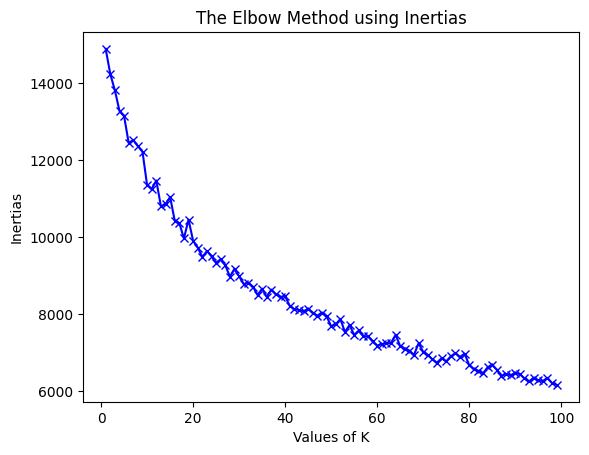

In [64]:
import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [67]:
num_clusters = 80
res = cluster_util.cluster_kmeans(X_tfidf, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [17]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_tfidf"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [18]:
## dbscan

In [19]:
eps_tfidf = cluster_util.epsilon_search_dbscan(X_tfidf)
print(eps_tfidf)
res = cluster_util.cluster_dbscan(X_tfidf, eps=eps_tfidf, min_samples=30)

0.7671202045161813
Estimated no. of clusters: 80
Estimated no. of noise points: 6361


In [20]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [21]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_tfidf"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [22]:
## OPTICS

In [23]:
res = cluster_util.cluster_optics(X_tfidf, min_samples = 30)

Estimated no. of clusters: 89
Estimated no. of noise points: 6696


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [24]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [25]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_tfidf"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

##### 2. sentence transformers

In [26]:
df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_transformers_1.txt', 'rb') as f:
    X_transformers1 = np.load(f)

In [27]:
## kmeans

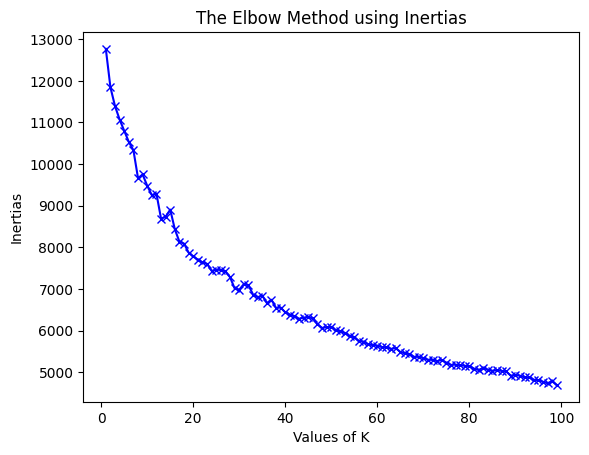

In [65]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_transformers, K_range = K_range) # X_transformers1

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [68]:
num_clusters = 80
res = cluster_util.cluster_kmeans(X_transformers, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [29]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_transformers"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [69]:
# transformer1
num_clusters = 80
res = cluster_util.cluster_kmeans(X_transformers1, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [31]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_transformers1"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [32]:
## dbscan

In [33]:
eps_transformers = cluster_util.epsilon_search_dbscan(X_transformers)
print(eps_transformers)
res = cluster_util.cluster_dbscan(X_transformers, eps=eps_transformers, min_samples=30)

0.6600872979744651
Estimated no. of clusters: 73
Estimated no. of noise points: 6313


In [34]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [35]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [36]:
# transformer 1
eps_transformers1 = cluster_util.epsilon_search_dbscan(X_transformers1)
print(eps_transformers1)
res = cluster_util.cluster_dbscan(X_transformers1, eps=eps_transformers1, min_samples=30)

0.4621702878316836
Estimated no. of clusters: 59
Estimated no. of noise points: 8309


In [37]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [38]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers1"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [39]:
## OPTICS

In [40]:
res = cluster_util.cluster_optics(X_transformers, min_samples = 30)

Estimated no. of clusters: 83
Estimated no. of noise points: 7017


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [41]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(49, df2_err_ename[['evalue','cluster']])

In [42]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_transformers"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [43]:
# transformer 1
res = cluster_util.cluster_optics(X_transformers1, min_samples = 30)

Estimated no. of clusters: 89
Estimated no. of noise points: 9213


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [44]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [45]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_transformers1"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

##### 3. word embeddings - GloVe

In [46]:
df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

In [39]:
## kmeans

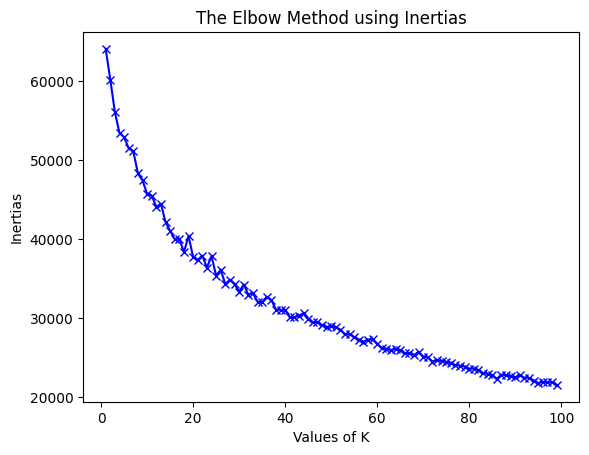

In [66]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_glove, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [70]:
num_clusters = 80
res = cluster_util.cluster_kmeans(X_glove, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

In [48]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_km_glove"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [49]:
## dbscan

In [50]:
eps_glove = cluster_util.epsilon_search_dbscan(X_glove)
print(eps_glove)
res = cluster_util.cluster_dbscan(X_glove, eps=eps_glove, min_samples=30)

0.9936201597249292
Estimated no. of clusters: 76
Estimated no. of noise points: 6354


In [51]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [52]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_glove"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

In [53]:
## OPTICS

In [54]:
res = cluster_util.cluster_optics(X_glove, min_samples = 30)

Estimated no. of clusters: 87
Estimated no. of noise points: 7068


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [55]:
df2_err_ename.loc[:,"cluster"] = res
#cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

In [56]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_optics_glove"})
df2_err_ename.to_excel(path_file, index=False, engine='xlsxwriter')

### 3. Evaluate vectorization and clustering methods

In [57]:
df2_err_ename.columns

Index(['fname', 'ename', 'evalue', 'evalue_tokenized', 'traceback',
       'lib_parsed', 'evalue_tokenized_transformer', 'cluster_km_tfidf',
       'cluster_dbscan_tfidf', 'cluster_optics_tfidf',
       'cluster_km_transformers', 'cluster_km_transformers1',
       'cluster_dbscan_transformers', 'cluster_dbscan_transformers1',
       'cluster_optics_transformers', 'cluster_optics_transformers1',
       'cluster_km_glove', 'cluster_dbscan_glove', 'cluster_optics_glove'],
      dtype='object')

In [58]:
import pandas as pd
import numpy as np
import cluster_util

path = r'C:\Users\yirwa29\Downloads\Dataset-Nb\nbdata_g_error\analysis_gerr\cluster_selection_g_valueerror'
path_file = path+"/nberror_g_cluster_valueerror.xlsx"

df2_err_ename = pd.read_excel(path_file)
with open(path+'/nberror_g_valueerror_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_transformers_1.txt', 'rb') as f:
    X_transformers1 = np.load(f)
with open(path+'/nberror_g_valueerror_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

In [74]:
arr_eval = np.zeros((3,4))
name_cols = ['tfidf','word2vec','transformer','transformer1']
name_rows = ['kmeans','dbscan','optics']

#ss_km_tfidf
arr_eval[0,0] = cluster_util.eval_cluster_silhouette(X_tfidf, df2_err_ename['cluster_km_tfidf'])
#ss_km_glove
arr_eval[0,1] = cluster_util.eval_cluster_silhouette(X_glove, df2_err_ename['cluster_km_glove'])
#ss_km_transformers
arr_eval[0,2] = cluster_util.eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_km_transformers'])
#ss_km_transformers1
arr_eval[0,3] = cluster_util.eval_cluster_silhouette(X_transformers1, df2_err_ename['cluster_km_transformers1'])

#ss_dbscan_tfidf
arr_eval[1,0] = cluster_util.eval_cluster_silhouette(X_tfidf[df2_err_ename['cluster_dbscan_tfidf']!=-1], 
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_tfidf']!=-1, 'cluster_dbscan_tfidf'])
#ss_dbscan_glove
arr_eval[1,1] = cluster_util.eval_cluster_silhouette(X_glove[df2_err_ename['cluster_dbscan_glove']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])
#ss_dbscan_transformers
arr_eval[1,2] = cluster_util.eval_cluster_silhouette(X_transformers[df2_err_ename['cluster_dbscan_transformers']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers']!=-1, 'cluster_dbscan_transformers'])
#ss_dbscan_transformers1
arr_eval[1,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_dbscan_transformers1']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers1']!=-1, 'cluster_dbscan_transformers1'])
#ss_optics_tfidf
arr_eval[2,0] = cluster_util.eval_cluster_silhouette(X_tfidf[df2_err_ename['cluster_optics_tfidf']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_tfidf']!=-1, 'cluster_optics_tfidf'])
#ss_optics_glove
arr_eval[2,1] = cluster_util.eval_cluster_silhouette(X_glove[df2_err_ename['cluster_optics_glove']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
#ss_optics_transformers
arr_eval[2,2] = cluster_util.eval_cluster_silhouette(X_transformers[df2_err_ename['cluster_optics_transformers']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_transformers']!=-1, 'cluster_optics_transformers'])
#ss_optics_transformers1
arr_eval[2,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_optics_transformers1']!=-1],
                                        df2_err_ename.loc[df2_err_ename['cluster_optics_transformers1']!=-1, 'cluster_optics_transformers1'])

In [75]:
df_eval = pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)
df_eval

,tfidf,word2vec,transformer,transformer1
kmeans,0.448367,0.391797,0.425322,0.252347
dbscan,0.852318,0.859828,0.806426,0.672226
optics,0.909886,0.950594,0.917535,0.758300


In [76]:
df_eval.to_excel(path+"/nberror_g_cluster_valueerror_eval.xlsx", index=False, engine='xlsxwriter')

selected optimal clustering method + wordembeddings = optics + word2vec(GloVe)

## Test the retrained word2vec vs. GloVe

on Optics

In [96]:
import pandas as pd 
import config
import cluster_util
import numpy as np

path_gvalue = config.path_github_error_process.joinpath("analysis_gerr/cluster_selection_g_valueerror/nberror_g_cluster_valueerror_re.xlsx")
df_err_gvalue = pd.read_excel(path_gvalue)
df_err_gvalue = df_err_gvalue[~df_err_gvalue.evalue.isnull()]
df_err_gvalue["evalue_tokenized"] = df_err_gvalue.evalue.apply(cluster_util.preprocess_text)
df_err_gvalue = df_err_gvalue[df_err_gvalue["evalue_tokenized"]!=""]
err_descs = df_err_gvalue['evalue_tokenized'].values.astype('U')

In [126]:
glove_vectors = cluster_util.load_glove(config.path_default.joinpath("glove.6B/glove.6B.200d.txt"))
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove_rd = cluster_util.pca(X_glove, n_component=20)
df_err_gvalue.loc[:,"cluster_optics_glove"] = cluster_util.cluster_optics(X_glove_rd, min_samples = 10)

Estimated no. of clusters: 244
Estimated no. of noise points: 5072


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [194]:
import importlib
importlib.reload(cluster_util)
import cluster_util

In [171]:
import retrain_word2vec,config

def cluster_with_w2v(model_name="nberr_word2vec.model", res_col_name="cluster_optics_w2v", n_comp=20, min_sam=10):
    w2v_model = retrain_word2vec.load_word2vec(config.path_w2v_models, model_name)
    X_w2v = np.array([cluster_util.vectorizer_word2vec(xi, w2v_model.wv, w2v_model.vector_size) for xi in err_descs])
    X_w2v_rd = cluster_util.pca(X_w2v, n_component=n_comp)
    df_err_gvalue.loc[:,res_col_name] = cluster_util.cluster_optics(X_w2v_rd, min_samples = min_sam)
    
    return cluster_util.eval_cluster_silhouette(X_w2v_rd[df_err_gvalue[res_col_name]!=-1],
                                        df_err_gvalue.loc[df_err_gvalue[res_col_name]!=-1, res_col_name])

sq_w2v = cluster_with_w2v()
sq_w2v_sg = cluster_with_w2v(model_name="nberr_word2vec_sg.model", res_col_name="cluster_optics_w2v_sg")
sq_w2v_finetune = cluster_with_w2v(model_name="nberr_word2vec_glove_finetune.model", res_col_name="cluster_optics_w2v_finetune")
sq_w2v_subword2vec = cluster_with_w2v(model_name="nberr_subword2vec.model", res_col_name="cluster_optics_w2v_subword2vec")
sq_w2v_subword2vec_finetune = cluster_with_w2v(model_name="nberr_subword2vec_finetune.model", res_col_name="cluster_optics_w2v_subword2vec_finetune")

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 257
Estimated no. of noise points: 4843


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 266
Estimated no. of noise points: 4681


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 249
Estimated no. of noise points: 4905


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 267
Estimated no. of noise points: 4743


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 258
Estimated no. of noise points: 4898


In [191]:
df_err_gvalue_optics_w2v = df_err_gvalue[['fname','evalue','evalue_tokenized','traceback',
               'cluster_optics_glove','cluster_optics_w2v','cluster_optics_w2v_sg',
               'cluster_optics_w2v_finetune','cluster_optics_w2v_subword2vec','cluster_optics_w2v_subword2vec_finetune']]
df_err_gvalue_optics_w2v.to_excel(config.path_w2v_models.joinpath("nberror_gvalueerror_w2v.xlsx"), index=False, engine='xlsxwriter')

In [195]:
ss_lev_glove, sum_lev_glove = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_glove","evalue")
ss_lev_w2v, sum_lev_w2v = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v","evalue")
ss_lev_w2v_sg, sum_lev_w2v_sg = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_sg","evalue")
ss_lev_w2v_finetune, sum_lev_w2v_finetune = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_finetune","evalue")
ss_lev_subword2vec, sum_lev_subword2vec = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_subword2vec","evalue")
ss_lev_subword2vec_finetune, sum_lev_subword2vec_finetune = cluster_util.statistics_lev(df_err_gvalue_optics_w2v, "cluster_optics_w2v_subword2vec_finetune","evalue")

In [196]:
arr_eval = np.zeros((4,6))
name_cols = ['word2vec_glove','word2vec_retrain','word2vec_retrain_sg','word2vec_finetune','word2vec_subword','word2vec_subword_finetune']
name_rows = ['optics_sh','optics_lev','optics_lev_std','n_noise']

#ss_optics_glove
sh_glove = cluster_util.eval_cluster_silhouette(X_glove_rd[df_err_gvalue_optics_w2v['cluster_optics_glove']!=-1],
                                                df_err_gvalue_optics_w2v.loc[df_err_gvalue_optics_w2v['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
arr_eval[:,0] = [sh_glove]+sum_lev_glove

#ss_optics_retrain
arr_eval[:,1] = [sq_w2v]+sum_lev_w2v
arr_eval[:,2] = [sq_w2v_sg]+sum_lev_w2v_sg
arr_eval[:,3] = [sq_w2v_finetune]+sum_lev_w2v_finetune
arr_eval[:,4] = [sq_w2v_subword2vec]+sum_lev_subword2vec
arr_eval[:,5] = [sq_w2v_subword2vec_finetune]+sum_lev_subword2vec_finetune

pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)

,word2vec_glove,word2vec_retrain,word2vec_retrain_sg,word2vec_finetune,word2vec_subword,word2vec_subword_finetune
optics_sh,0.953132,0.933851,0.926862,0.933302,0.935934,0.938355
optics_lev,0.888208,0.877235,0.875494,0.864804,0.875079,0.885882
optics_lev_std,0.056430,0.059839,0.061053,0.056993,0.061892,0.056804
n_noise,0.326174,0.311447,0.301029,0.315434,0.305016,0.314984


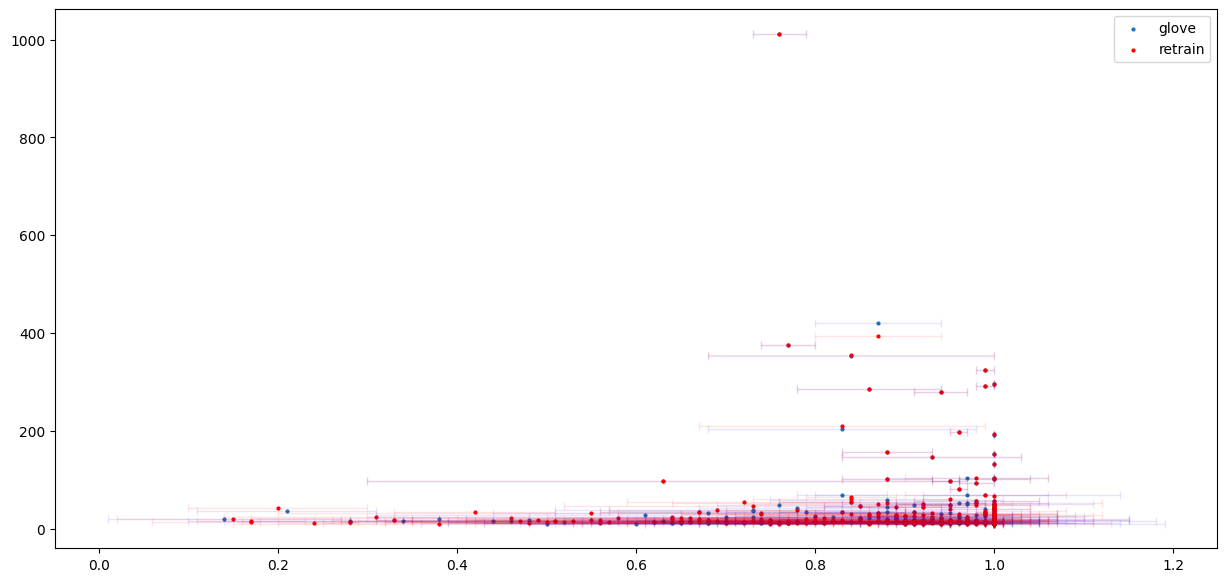

In [131]:
import matplotlib.pyplot as plt
import math

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(ss_lev_glove['mean_similarity'], ss_lev_glove.cluster_size, label = 'glove', s=4)
ax.errorbar(ss_lev_glove['mean_similarity'], ss_lev_glove.cluster_size, xerr=ss_lev_glove['std_similarity'], 
             lw=1, capsize=3, ecolor=(0.0,0.0,1.0,0.1), ls='none')

ax.scatter(ss_lev_w2v['mean_similarity'], ss_lev_w2v.cluster_size, label = 'retrain', s=4, color="r")
ax.errorbar(ss_lev_w2v['mean_similarity'], ss_lev_w2v.cluster_size, xerr=ss_lev_w2v['std_similarity'], 
             lw=1, capsize=3, ecolor=(1.0,0.0,0.0,0.1), ls='none')
ax.legend()
plt.show()